In [1]:
cd C:\Users\ysyang\Documents\yongsoo\Teaching\2025_Spring_Comp_Physics\DL_augmentation

[WinError 3] 지정된 경로를 찾을 수 없습니다: 'C:\\Users\\ysyang\\Documents\\yongsoo\\Teaching\\2025_Spring_Comp_Physics\\DL_augmentation'
c:\workspace\physics\ph413-comp-ph\ta-session\session-11


In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage, datasets, interpolate
import scipy as sp
import tqdm
import os

import radon_transformation

In [2]:
# Number of training, validation, and test sets
num_training_sets = 1000
num_validation_sets = 200
num_test_sets = 10

# Tilt angles
angle_list = np.arange(-70, 70, 4)

# Image size parameters
dim0 = 128
dim1 = 128

# Random circle min / max radius for creating random shape area (in pixels)
rand_circle_rad_min = 3
rand_circle_rad_max = 25

# Minimum distance from the edge of image for the random shape (in pixels)
min_dist_from_edge = 5

# Minimum & maximum area (in pixels)
min_area = 5000
max_area = 11000

# Probability of continuing random circle addition for shape generation
continue_loop_prob = 0.9

# Atomic structure parameters
atom_min_dist = 2.0        # Angstrom
target_density_dist = 2.5  # Angstrom
target_fill_ratio = 0.90
pixel_size = 0.4           # Angstrom
atom_gauss_sigma = 0.45    # Angstrom

crop_half_width = 3  # pixels


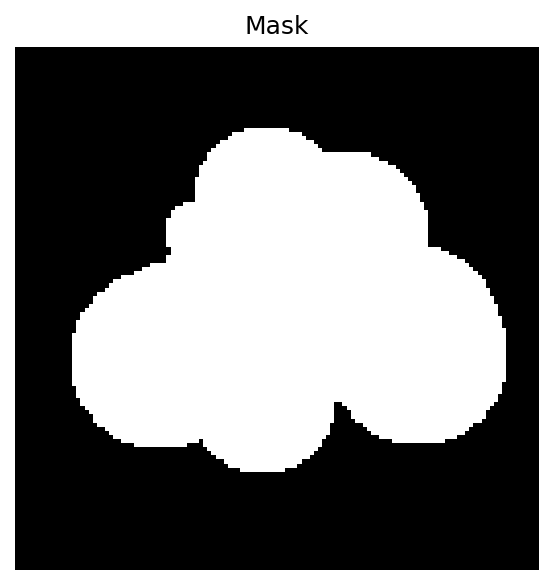

In [ ]:
def create_random_mask(
    dim0: int,
    dim1: int,
    min_dist_from_edge: int,
    rand_circle_rad_min: int,
    rand_circle_rad_max: int,
    min_area: int,
    max_area: int,
    continue_loop_prob: float,
) -> np.ndarray:
    '''
    Generate a random 2‑D binary mask composed of overlapping circles.

    Returns
    -------
    mask : np.ndarray
        Binary image of shape (dim0, dim1) containing the generated mask.
    '''
    mask = np.zeros((dim0, dim1), dtype=np.uint8)

    grid0, grid1 = np.meshgrid(np.arange(dim0), np.arange(dim1), indexing='ij')

    # The object should be within this big circle to avoid edge artifacts
    big_circle = (
        (grid0 - dim0 / 2) ** 2 + (grid1 - dim1 / 2) ** 2
    ) < (dim0 / 2 - min_dist_from_edge) ** 2

    continue_flag = True
    while continue_flag:
        # Random center coordinates and radius for the new circle
        rand_ind0 = np.random.randint(0, dim0)
        rand_ind1 = np.random.randint(0, dim1)
        rand_rad = np.random.randint(rand_circle_rad_min, rand_circle_rad_max)

        # Create candidate circle
        curr_circle = (
            (grid0 - rand_ind0) ** 2 + (grid1 - rand_ind1) ** 2
        ) < rand_rad ** 2

        # Reject if any part of the candidate circle falls outside the big circle
        if np.any(curr_circle & (~big_circle)):
            continue

        # Ensure connectivity: if the mask already has content, the new circle
        # must overlap at least one existing pixel.
        if mask.sum() > 0 and mask[rand_ind0, rand_ind1] == 0:
            continue

        # Add the circle to the mask
        mask[curr_circle] = 1

        # Decide whether to continue adding circles
        current_area = mask.sum()
        if current_area > min_area:
            if np.random.uniform() > continue_loop_prob or current_area > max_area:
                continue_flag = False

    return mask

mask = create_random_mask(
    dim0=dim0,
    dim1=dim1,
    min_dist_from_edge=min_dist_from_edge,
    rand_circle_rad_min=rand_circle_rad_min,
    rand_circle_rad_max=rand_circle_rad_max,
    min_area=min_area,
    max_area=max_area,
    continue_loop_prob=continue_loop_prob,
)

plt.figure(figsize=(4, 4), dpi=150)
plt.imshow(mask, cmap="gray", interpolation="nearest")
plt.axis("off")
plt.title("Mask")
plt.tight_layout()
plt.show()

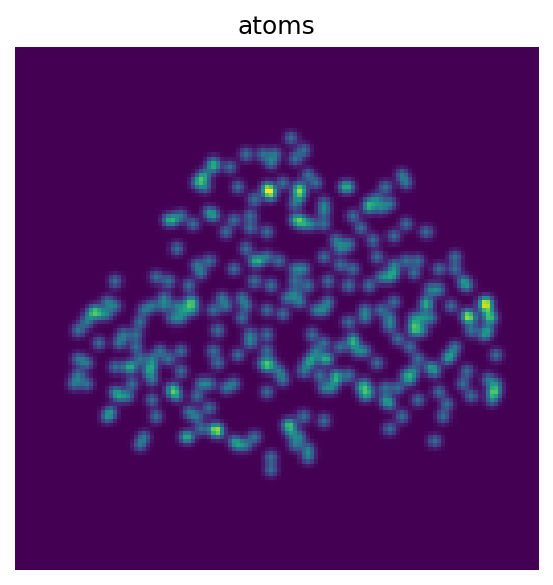

In [5]:
def create_image_from_atomic_structure(
    dim0: int,
    dim1: int,
    atom_pos_arr: np.ndarray,
    atom_gauss_sigma: float,
    crop_half_width: int,
    pixel_size: float,
) -> np.ndarray:
    """Render a grayscale image by placing 2‑D Gaussian blobs at atomic positions.

    Parameters
    ----------
    dim0, dim1 : int
        Output image dimensions in pixels.
    atom_pos_arr : (N, 2) ndarray
        Atomic coordinates **in pixel units** – (row, col) for each atom.
    atom_gauss_sigma : float
        Standard deviation of atomic Gaussian **in Å**.
    crop_half_width : int
        Half–width (pixels) of the square patch used to place each Gaussian.
    pixel_size : float
        Physical pixel size (Å / pixel) used to convert *atom_gauss_sigma*.

    Returns
    -------
    image : np.ndarray (float32)
        Simulated projection image.
    """

    image = np.zeros((dim0, dim1), dtype=np.float32)

    # Pre‑compute a Gaussian kernel on a fixed grid
    offset = np.arange(-crop_half_width, crop_half_width + 1)
    g_grid0, g_grid1 = np.meshgrid(offset, offset, indexing="ij")
    sigma_pix = atom_gauss_sigma / pixel_size
    gaussian_kernel = np.exp(-(g_grid0**2 + g_grid1**2) / (2 * sigma_pix**2))

    patch_size = 2 * crop_half_width + 1

    for center_row, center_col in np.round(atom_pos_arr).astype(int):
        # Pixel indices covered by the patch
        rows = np.arange(center_row - crop_half_width, center_row + crop_half_width + 1)
        cols = np.arange(center_col - crop_half_width, center_col + crop_half_width + 1)

        # Valid rows/cols within image boundaries
        valid_rows = (rows >= 0) & (rows < dim0)
        valid_cols = (cols >= 0) & (cols < dim1)

        if not (valid_rows.any() and valid_cols.any()):
            # Atom completely outside FOV
            continue

        # Map valid rows/cols into image indices
        img_rows = rows[valid_rows]
        img_cols = cols[valid_cols]

        # Corresponding slice of the Gaussian kernel
        ker_rows = np.where(valid_rows)[0]
        ker_cols = np.where(valid_cols)[0]
        image[np.ix_(img_rows, img_cols)] += gaussian_kernel[np.ix_(ker_rows, ker_cols)]

    return image

mask_indices = np.column_stack(np.nonzero(mask))
num_atoms = 300
rng = np.random.default_rng(seed=42)
chosen_indices = mask_indices[rng.choice(mask_indices.shape[0], num_atoms, replace=False)]

atomic_image = create_image_from_atomic_structure(
    dim0=dim0,
    dim1=dim1,
    atom_pos_arr=chosen_indices,  # already in pixel units
    atom_gauss_sigma=atom_gauss_sigma,
    crop_half_width=crop_half_width,
    pixel_size=pixel_size,
)

plt.figure(figsize=(4, 4), dpi=150)
plt.imshow(atomic_image, cmap="viridis", interpolation="nearest")
plt.axis("off")
plt.title("atoms")
plt.tight_layout()
plt.show()

In [6]:
def create_data_from_gt(
    gt_image_array: np.ndarray,
    angle_arr: np.ndarray,
) -> np.ndarray:
    """
    Simulate tomography: forward Radon transform + filtered back-projection.

    Parameters
    ----------
    gt_image_array : ndarray
        Ground-truth 이미지 스택 (H × W × N).
    angle_arr : ndarray
        투영 각도(°).

    Returns
    -------
    data_image_array : ndarray
        재구성된 이미지 스택, gt_image_array와 동일 형상.
    """
    data_image_array = np.zeros_like(gt_image_array, dtype=np.float32)
    num_slices = gt_image_array.shape[2]

    for img_idx in tqdm.trange(num_slices):
        # forward projection (sinogram)
        sinogram = radon_transformation.radon_transform(
            gt_image_array[:, :, img_idx],
            angle_arr,
        )
        # inverse Radon (filtered back-projection)
        data_image_array[:, :, img_idx] = radon_transformation.iradon_transform(
            sinogram,
            angle_arr,
            interpolation="cubic",
        )

    return data_image_array

In [16]:
def create_training_data(
    dim0: int,
    dim1: int,
    min_dist_from_edge: int,
    rand_circle_rad_min: int,
    rand_circle_rad_max: int,
    min_area: int,
    max_area: int,
    continue_loop_prob: float,
    num_data: int,
    target_density_dist: float,
    target_fill_ratio: float,
    pixel_size: float,
    crop_half_width: int,
    atom_min_dist: float,
    atom_gauss_sigma: float,
):
    """
    무작위 2-D shape + 원자 위치를 생성해 ground-truth 이미지/마스크/좌표 리스트를 반환합니다.
    """
    gt_mask_array  = np.zeros((dim0, dim1, num_data), dtype=np.uint8)
    gt_image_array = np.zeros((dim0, dim1, num_data), dtype=np.float32)
    gt_pos_list:   list[np.ndarray] = []

    grid0, grid1 = np.meshgrid(np.arange(dim0), np.arange(dim1), indexing="ij")
    min_dist_pix = atom_min_dist / pixel_size  # 최소 간격(픽셀 단위)

    for img_idx in tqdm.trange(num_data):
        # 1) 무작위 shape 생성
        mask = create_random_mask(
            dim0,
            dim1,
            min_dist_from_edge,
            rand_circle_rad_min,
            rand_circle_rad_max,
            min_area,
            max_area,
            continue_loop_prob,
        )

        # 2) 원자 좌표 생성
        atom_pos_arr = np.empty((0, 2), dtype=np.float32)

        # 목표 원자 수 계산
        phys_area      = mask.sum() * pixel_size**2            # Å²
        target_num     = int(
            np.round(phys_area / (target_density_dist**2) * target_fill_ratio)
        )

        while atom_pos_arr.shape[0] < target_num:
            # 후보 좌표 (물리 단위 × 픽셀 단위 각각)
            rand_pos0 = np.random.uniform() * dim0
            rand_pos1 = np.random.uniform() * dim1

            # 후보 원이 shape 밖으로 나가면 패스
            curr_circle = (
                (grid0 - rand_pos0) ** 2 + (grid1 - rand_pos1) ** 2
            ) <= crop_half_width**2
            if (curr_circle & (mask == 0)).any():
                continue

            # 기존 원자들과 최소 거리 조건
            if atom_pos_arr.shape[0] > 0:
                d2 = np.sum((atom_pos_arr - np.array([rand_pos0, rand_pos1])) ** 2, axis=1)
                if (d2 < min_dist_pix**2).any():
                    continue

            # 통과한 경우 좌표 추가
            atom_pos_arr = np.vstack([atom_pos_arr, [rand_pos0, rand_pos1]])

        # 3) 결과 저장
        gt_mask_array[:, :, img_idx] = mask

        gt_image_array[:, :, img_idx] = create_image_from_atomic_structure(
            dim0,
            dim1,
            atom_pos_arr,
            atom_gauss_sigma,
            crop_half_width,
            pixel_size,
        )

        gt_pos_list.append(atom_pos_arr)

    return gt_image_array, gt_mask_array, gt_pos_list

In [8]:
# Create Training Datasets

# Create Ground Truth Images based on Random Volume and Random Atomic Structure
training_gt_image_array, training_gt_mask_array, training_gt_pos_list = create_training_data(
    dim0=dim0,
    dim1=dim1,
    min_dist_from_edge=min_dist_from_edge,
    rand_circle_rad_min=rand_circle_rad_min,
    rand_circle_rad_max=rand_circle_rad_max,
    min_area=min_area,
    max_area=max_area,
    continue_loop_prob=continue_loop_prob,
    num_data=num_training_sets,
    target_density_dist=target_density_dist,
    target_fill_ratio=target_fill_ratio,
    pixel_size=pixel_size,
    crop_half_width=crop_half_width,
    atom_min_dist=atom_min_dist,
    atom_gauss_sigma=atom_gauss_sigma,
)

# 투영·재구성까지 이어서 진행
training_data_image_array = create_data_from_gt(training_gt_image_array, angle_list)


100%|██████████| 1000/1000 [01:25<00:00, 11.64it/s]


In [12]:
data_dir = "./data_temp/"
os.makedirs(data_dir, exist_ok=True)

In [28]:
# Save The generated data

np.save(os.path.join(data_dir, "training_data.npy"), training_data_image_array)
np.save(os.path.join(data_dir, "training_gt.npy"), training_gt_image_array)
np.save(os.path.join(data_dir, "training_gt_mask.npy"), training_gt_mask_array)

np.save(os.path.join(data_dir, 'training_atom_pos.npy'), np.array(training_gt_pos_list, dtype=object), allow_pickle=True)

In [17]:
validation_gt_image_array, validation_gt_mask_array, validation_gt_pos_list = create_training_data(
    dim0=dim0,
    dim1=dim1,
    min_dist_from_edge=min_dist_from_edge,
    rand_circle_rad_min=rand_circle_rad_min,
    rand_circle_rad_max=rand_circle_rad_max,
    min_area=min_area,
    max_area=max_area,
    continue_loop_prob=continue_loop_prob,
    num_data=num_validation_sets,
    target_density_dist=target_density_dist,
    target_fill_ratio=target_fill_ratio,
    pixel_size=pixel_size,
    crop_half_width=crop_half_width,
    atom_min_dist=atom_min_dist,
    atom_gauss_sigma=atom_gauss_sigma,
)

validation_data_image_array = create_data_from_gt(validation_gt_image_array, angle_list)

100%|██████████| 200/200 [00:16<00:00, 12.23it/s]


In [29]:
np.save(os.path.join(data_dir, "validation_data.npy"), validation_data_image_array)
np.save(os.path.join(data_dir, "validation_gt.npy"), validation_gt_image_array)
np.save(os.path.join(data_dir, "validation_gt_mask.npy"), validation_gt_mask_array)

np.save(os.path.join(data_dir, 'validation_atom_pos.npy'), np.array(validation_gt_pos_list, dtype=object), allow_pickle=True)

In [20]:
# Create Test Datasets

test_gt_image_array, test_gt_mask_array, test_gt_pos_list = create_training_data(
    dim0=dim0,
    dim1=dim1,
    min_dist_from_edge=min_dist_from_edge,
    rand_circle_rad_min=rand_circle_rad_min,
    rand_circle_rad_max=rand_circle_rad_max,
    min_area=min_area,
    max_area=max_area,
    continue_loop_prob=continue_loop_prob,
    num_data=num_test_sets,
    target_density_dist=target_density_dist,
    target_fill_ratio=target_fill_ratio,
    pixel_size=pixel_size,
    crop_half_width=crop_half_width,
    atom_min_dist=atom_min_dist,
    atom_gauss_sigma=atom_gauss_sigma,
)

test_data_image_array = create_data_from_gt(test_gt_image_array, angle_list)

100%|██████████| 10/10 [00:00<00:00, 12.74it/s]


In [30]:
np.save(os.path.join(data_dir, "test_data.npy"), test_data_image_array)
np.save(os.path.join(data_dir, "test_gt.npy"), test_gt_image_array)
np.save(os.path.join(data_dir, "test_gt_mask.npy"), test_gt_mask_array)

np.save(os.path.join(data_dir, 'test_atom_pos.npy'), np.array(test_gt_pos_list, dtype=object), allow_pickle=True)

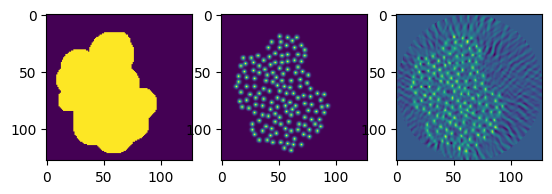

In [22]:
AA = 0
ax1 = plt.subplot(1, 3, 1)
plt.imshow(test_gt_mask_array[:,:,AA])
ax1 = plt.subplot(1, 3, 2)
plt.imshow(test_gt_image_array[:,:,AA])
ax1 = plt.subplot(1, 3, 3)
plt.imshow(test_data_image_array[:,:,AA])

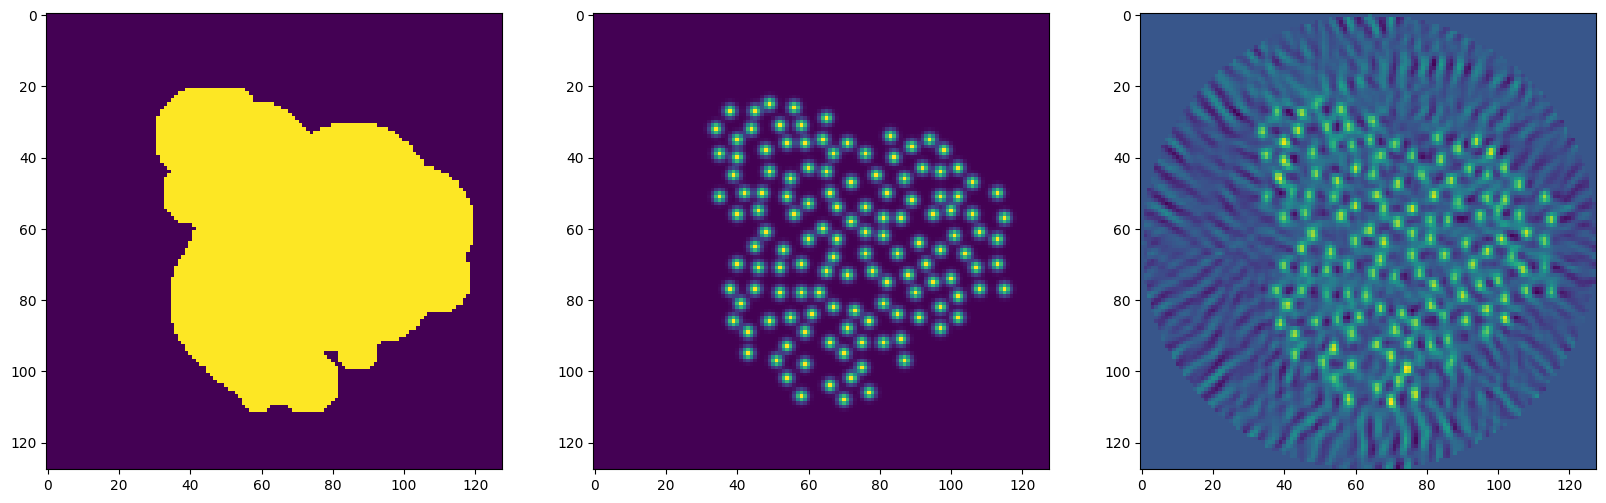

In [23]:

f = plt.figure(figsize=(20,6))
ax = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)

ax.imshow(training_gt_mask_array[:,:,AA])
ax2.imshow(training_gt_image_array[:,:,AA])
ax3.imshow(training_data_image_array[:,:,AA])


In [25]:
len(test_gt_pos_list[0])

147